In [4]:
from brian2 import *

import brian2 as b2

In [15]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time

b2.defaultclock.dt = 0.10 * b2.ms

In [5]:

# remember, this is here for running separate simulations in the same notebook
start_scope()
# Parameters

N_Excit=384 
N_Inhib=96 
weight_scaling_factor=5.33
t_stimulus_start=100 * b2.ms 
t_stimulus_duration=9999 * b2.ms 
coherence_level=0
stimulus_update_interval=30 * b2.ms
mu0_mean_stimulus_Hz=160
w_pos=1.90
firing_rate_extern=9.8 * b2.Hz
N_extern=1000 
stimulus_std_Hz=20.
f_Subpop_size=0.25  # .15 in publication [1]
max_sim_time=1000. * b2.ms 
stop_condition_rate=None
monitored_subset_size=512

In [8]:
print("simulating {} neurons. Start: {}".format(N_Excit + N_Inhib, time.ctime()))
t_stimulus_end = t_stimulus_start + t_stimulus_duration

N_Group_A = int(N_Excit * f_Subpop_size)  # size of the excitatory subpopulation sensitive to stimulus A
N_Group_B = N_Group_A  # size of the excitatory subpopulation sensitive to stimulus B
N_Group_Z = N_Excit - N_Group_A - N_Group_B  # (1-2f)Ne excitatory neurons do not respond to either stimulus.

Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons0
G_leak_excit = 25.0 * b2.nS  # leak conductance
E_leak_excit = -70.0 * b2.mV  # reversal potential
v_spike_thr_excit = -50.0 * b2.mV  # spike condition
v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

simulating 480 neurons. Start: Mon Jan  9 13:37:07 2023


In [9]:
# specify the AMPA synapses
E_AMPA = 0.0 * b2.mV
tau_AMPA = 2.5 * b2.ms

# specify the GABA synapses
E_GABA = -70.0 * b2.mV
tau_GABA = 5.0 * b2.ms

# specify the NMDA synapses
E_NMDA = 0.0 * b2.mV
tau_NMDA_s = 100.0 * b2.ms
tau_NMDA_x = 2. * b2.ms
alpha_NMDA = 0.5 * b2.kHz

In [10]:
# projections from the external population
g_AMPA_extern2inhib = 1.62 * b2.nS
g_AMPA_extern2excit = 2.1 * b2.nS

In [11]:
 # projectsions from the inhibitory populations
g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

# projections from the excitatory population
g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

In [12]:
# weights and "adjusted" weights.
w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
# We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
# other weights are 1
# print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))

In [13]:
excit_lif_dynamics = """
    dv/dt = (
    - G_leak_excit * (v-E_leak_excit)
    - g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
    )/Cm_excit : volt (unless refractory)
    ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
"""

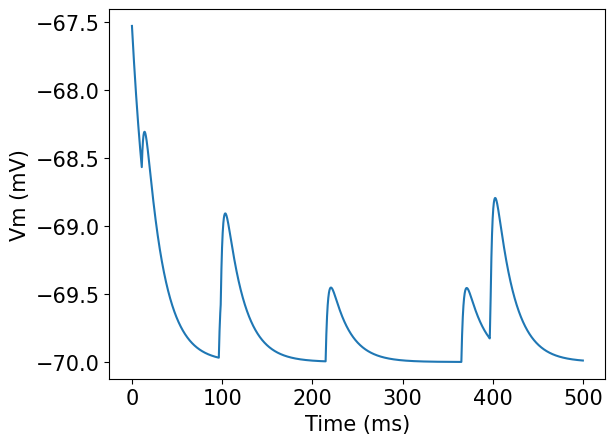

In [64]:
# remember, this is here for running separate simulations in the same notebook
start_scope()
# Parameters

excit_pop_A = NeuronGroup(1, model=excit_lif_dynamics,
                              threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                              refractory=t_abs_refract_excit, method="rk2")


excit_pop_A.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5., size=excit_pop_A.N) * b2.mV

poisson2A = PoissonInput(target=excit_pop_A, target_var="s_AMPA",
                             N=1, rate=firing_rate_extern, weight=w_ext2excit)


M = StateMonitor(excit_pop_A, 'v', record=True)

b2.run(500*b2.ms)
b2.plot(M.t/b2.ms, M.v[0]/b2.mV)
plt.rcParams.update({'font.size': 15})
plt.savefig("ampa_synaptic_input.svg", transparent=True)
xlabel('Time (ms)')
ylabel('Vm (mV)');